# SQLITE Database Analysis

Requires parts database to already be downloaded and unzipped ```jlcpcb-components.sqlite3``` (the code can be found in sqlite-search.ipynb)

[Setup Python Virtual Environment in VSCode](/venv-setup.md)

In [3]:
import sqlite3

conn = sqlite3.connect(r"jlcpcb-components.sqlite3")
cur = conn.cursor()
freelist_count = cur.execute("PRAGMA freelist_count").fetchone()[0]
page_size = cur.execute("PRAGMA page_size").fetchone()[0]
page_count = cur.execute("PRAGMA page_count").fetchone()[0]

cur.execute("SELECT COUNT(*) FROM components")
total_rows = cur.fetchone()[0]

conn.close()

print(f"Unused Pages: {freelist_count:,} Used Pages: {page_count:,} Page size: {page_size:,} Bytes")
print(f"Number of Components: {total_rows:,}")

Unused Pages: 0 Used Pages: 262,290 Page size: 4,096 Bytes
Number of Components: 304,635


In [ ]:
%pip install matplotlib
%pip install numpy

Warning this code requires that you download the full cache.sqlite from yaqwsx/jlcparts and put it in the db-build folder

Approximate Total Cost: $67,851,098 USD


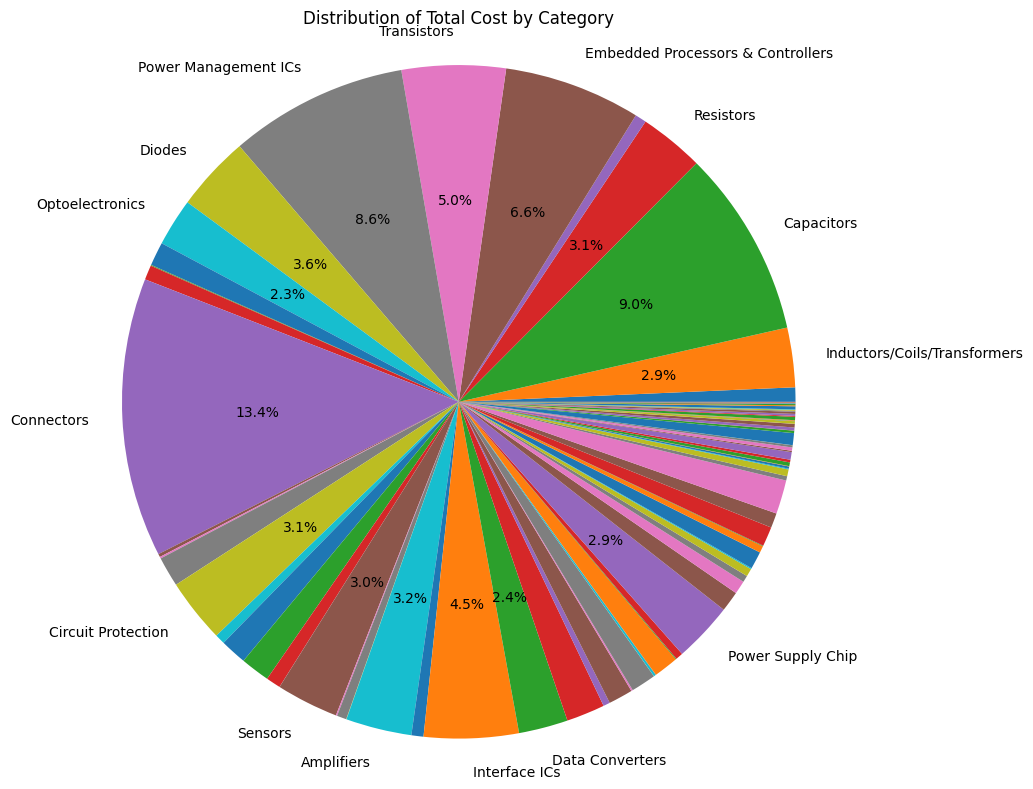

In [ ]:
import sqlite3
import json
import matplotlib.pyplot as plt

def calculate_total_cost(price_structure, quantity):
    for tier in price_structure:
        tier_qFrom = tier['qFrom']
        tier_qTo = tier['qTo']
        if quantity >= tier_qFrom:
            if tier_qTo is None:
                return quantity * tier['price']
            elif quantity <= tier_qTo:
                return quantity * tier['price']
    if price_structure != [] and price_structure != None:
        return quantity * price_structure[0]['price']  # Return lowest tier if no tier matches
    else:
        # print(f"Missing price_structure = {price_structure}")
        return 0.0

def calculate_total_cost_of_all_components(conn):
    cur = conn.cursor()
    # Retrieve all components' stock quantities, prices, and categories
    cur.execute("SELECT stock, price, category FROM v_components")
    components = cur.fetchall()
    total_cost = 0.0
    # Dictionary to hold total cost per category
    cost_per_category = {}
    
    for component in components:
        quantity = component[0]
        price_structure = json.loads(component[1])
        category = component[2]
        # Calculate cost for this component
        cost = calculate_total_cost(price_structure, quantity)
        # Update total cost
        total_cost += cost
        # Update cost per category
        if category in cost_per_category:
            cost_per_category[category] += cost
        else:
            cost_per_category[category] = cost
    return total_cost, cost_per_category

# Connect to the database and calculate total cost
conn = sqlite3.connect(r"db_build\\cache.sqlite3")
total_cost, cost_per_category = calculate_total_cost_of_all_components(conn)
conn.close()

# Print the approximate total cost
print(f"Approximate Total Cost: ${total_cost:,.0f} USD")

label_threshold = 2

# Prepare data for pie chart
categories = list(cost_per_category.keys())
category_costs = list(cost_per_category.values())
total_cost = sum(category_costs)

# Function to format the percentage display, only showing for values >= 1%
def format_percentage(percentage):
    if percentage >= label_threshold:
        return f'{percentage:.1f}%'
    else:
        return ''

# Create pie chart
plt.figure(figsize=(10, 8))
plt.pie(category_costs,
        labels=[f'{category}' 
                if ((cost / total_cost) * 100) >= label_threshold 
                else '' 
                for category, cost in zip(categories, category_costs)],
        autopct=format_percentage)
plt.title('Distribution of Total Cost by Category')
plt.axis('equal')

# Show the plot
plt.tight_layout()
plt.show()
